# Projeto de geometria de torre 525 kV
Torre cross-rope feixe convencional- Comparação entre critérios de norma

Resultados esperados conforme projeto:

Ângulo de balanço (°)

| Solicitação |     |
|-------------|-----|
| Tensão máxima operativa | 42 |
| Surto de manobra | 20 |
| Descargas atmosféricas | - |

Distâncias de isolamento (m)

| Solicitação | Fases externas | Fase central | Fase-fase |
|-------------|----------------|--------------|-----------|
| Tensão máxima operativa | 1.2 | 1.2 | 1.75 |
| Surto de manobra | 2.95 | 3.6 | 5.00 |
| Descargas atmosféricas | 3.75 | 3.75 | - |

Projeto assume distância de projeto entre centro de fases de 7 m, obtendo distância entre subcondutores entre fases de 6.55 m.

In [1]:
import normaslt as lt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from tabulate import tabulate
from normaslt import nbr1985, nbr5422
from math import ceil, degrees, radians, sin, cos, sqrt, exp
from IPython.display import HTML, display
from normaslt.geral import dbCabo
from normaslt.draw import find_line_start, minDistancePts, plot_dimension, plot_balanco, plot_cadeia, plot_distance_radius, plot_line_pt, xmax
from normaslt.types import amp, obs
from normaslt.cigre import anguloBalancoTB348

In [2]:
# Dados de projeto
vNom = 525.
vMax = 550.
ftmo = vMax/vNom
# Cabo e vão
cond = dbCabo.CAA_RAIL
ncond = 4
espCond = 0.457
vVento = 490 # vão médio (vento)
vpvm = 0.7 # Relação vão de peso/ vão de vento
vPeso = vVento * vpvm # vão de peso (gravante)
eds = 0.2
# Variáveis climatológicas e ambientais
tmed = 18. # Temperatura media (NBR 5422:1985, Anexo A, fig. 23)
tmedmin = 13. # Média das temperaturas mínimas, ou coincidente (NBR 5422:1985, Anexo A, fig. 27)
dra = 0.91
alt = 400 # Altitude média
FCAfi = 0.94 # confirmar
FCAim = 0.91
# Estrutura (mastro)
ht = 20.
d = 2.
s = 1.5
deltaH = 0.777 # Diferença de altura (drop) entre fase central e lateral pelo "cabo-travessa"
angM = 5 # ângulo do mastro em relação a vertical (graus)
# Sobretensões de manobra (pu)
muft98 = 2.5
muff98 = 2.5
sigma = 0.1
alpha = 0.5
# Fatores de gaps frente lenta
# "condutor-estrutura lateral"
kgfn = 1.45 + 0.35*(exp(-8. * s/d)-0.2) # Pegando cálculo na ref. Cigre original
kgff = 1.62 # "condutor-condutor", alpha 0.5
# Ventos de projeto - distribuição Gumbel
gumbelAlfa = 0.25
gumbelBeta = 16
# Temperatura de operação (°C) - valores arbitrados (sem relação com o projeto original)
ttipn = 50 # 15% risco térmico
ttips = 60 # 5% risco térmico
tlims = 70 # 1% risco térmico
# Cadeia de isoladores
dIsol = 0.280
passoIsol = 0.170
distEscoam = 0.380
Decr = 14 # distância de escoamento (mm/kVff) - poluição muito leve.
lFerragem = 0.1 # Comprimento adicional por ferragem (superior e inferior)

## Elementos em comum

### Cadeia de isoladores
(não referenciado na NBR 5422:1985 mas de prática comum)
$$
n = \left\lceil \frac{V_{\max} \, D_{ecr}}{D_{esc}} \right\rceil + n_{ex}
$$
Sendo $V_{\max}$ a tensão operativa máxima de linha, $D_{esc}$ a relação de distância de escoamento, $D_{esc}$ a distância de escoamento por isolador, $n_{ex}$ a previsão de número de isoladores extras e $\lceil x \rceil$ a operação de arredondar para cima.

### Flecha
Pode-se usar aproximação da parábola:
$$
f = \frac{p \, A^2}{8 \, T}
$$
Sendo $p$ o peso linear do cabo (N/m), $A$ o commprimento do vão (m) e $T$ a tração aplicada (N). A partir da flecha de referência (EDS), calcula-se as outras condições de temperatura pelas equações de estado.

In [3]:
# Cadeia de isoladores
nc = ceil(vMax * Decr / (distEscoam * 1e3)) + 1
lcadeia = nc * passoIsol + lFerragem
print(f"Cadeia de {nc} isoladores, comprimento {lcadeia:.2f} m.")
# A partir do número de isoladores, obtem-se os dados de suportabilidade de frente rápida (catálogo Hubbell, p. 124)
cfop = 2010
cfon = 2080
piso = 300 * 9.8 # TODO temporário - calcular
aiso = 1.5 # TODO temporário - calcular

# Flechas
f18 = lt.geral.flecha2(cond.p, vVento, cond.T * eds) # Na ref. indica 21 m, não ficou claro qual foi a condição, aparentemente em torno de 50°C.
f50, _ = lt.geral.equacaoEstado(cond.p, vVento, cond.T * eds, cond.S, cond.E, cond.alfa1, tmed, ttipn)
f60, _ = lt.geral.equacaoEstado(cond.p, vVento, cond.T * eds, cond.S, cond.E, cond.alfa1, tmed, ttips)
f70, _ = lt.geral.equacaoEstado(cond.p, vVento, cond.T * eds, cond.S, cond.E, cond.alfa1, tmed, tlims)
print(f"Flechas: EDS {f18:.2f} m, 50ºC: {f50:.2f} m, 60ºC: {f60:.2f} m, 70ºC: {f70:.2f} m.")


Cadeia de 22 isoladores, comprimento 3.84 m.
Flechas: EDS 19.72 m, 50ºC: 21.09 m, 60ºC: 21.51 m, 70ºC: 21.92 m.


## Parte 0 - projeto de referência

Plotação da cabeça de torre conforme referência.

Cálculo dos ângulos de balanço com velocidade de vento com tempo de retorno de 30 anos (39.4 m/s) e vento reduzido em 60% (23.6 m/s).

Os ângulos também foram acrescidos considerando a deflexão máxima considerada para a torre (2°)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


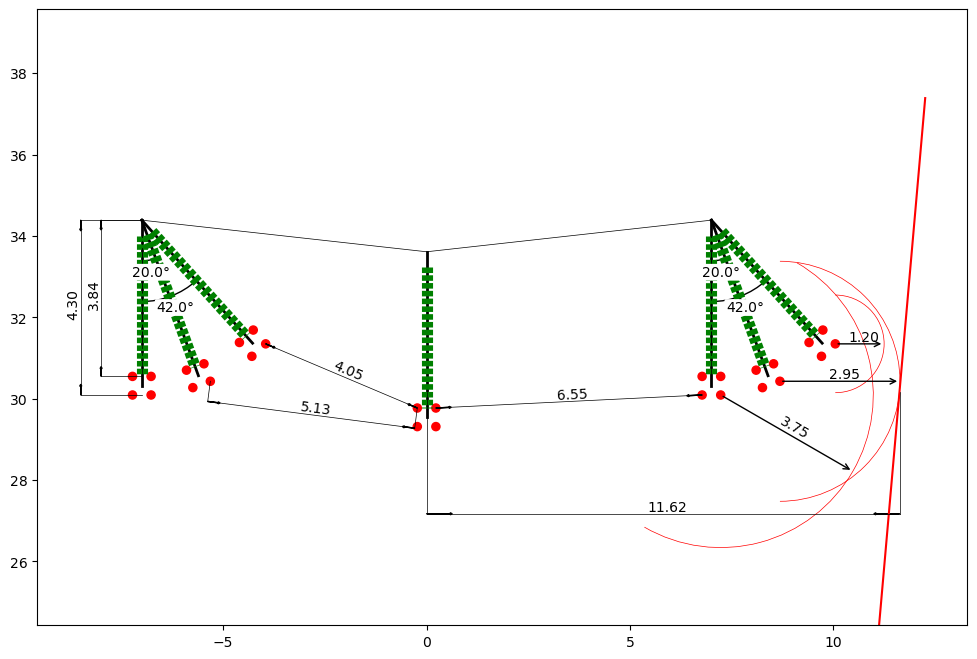

In [4]:
# Posição das fases
x2 = 0
dx = 7.
x1 = x2 - dx
x3 = x2 + dx
# Altura cabo-solo, na torre
hTorre = 29.77
y2 = hTorre
deltaH = 0.777
y1 = y2 + deltaH
y3 = y2 + deltaH
y1t = y1 + lcadeia
y2t = y2 + lcadeia
y3t = y3 + lcadeia
ang1 = 42.
ang2 = 20.
dist1 = 1.2
dist2 = 2.95
dist3 = 3.75

ax = plt.figure()
ax.figure.set_size_inches(12, 8)
plt.plot([-8, 8], [0, 0],'k-', linewidth=0.5)
ptsF2 = plot_cadeia(plt, (x2,y2t), l=lcadeia, ang=0, nc=4, angsc=45, esp=espCond, wcad=8)
plt.plot([x1, x2, x3], [y1t, y2t, y3t],'k-', linewidth=0.5)
ptsF1 = plot_cadeia(plt, (x1,y1t), l=lcadeia, ang=0, nc=4, angsc=45, esp=espCond, wcad=8)
plot_dimension(plt, (x1,y1), (x1,y1t), offset=1)
plot_dimension(plt, (x1,y1-espCond), (x1,y1t), offset=1.5)
ptsF3fr = plot_cadeia(plt, (x3,y3t), l=lcadeia, ang=0, nc=4, angsc=45, esp=espCond, wcad=8)
p1,p2,_ = minDistancePts(ptsF2, ptsF3fr)
plot_dimension(plt, p1, p2, offset=0)
pm = ptsF3fr[3]
plot_distance_radius(plt, pm, radius=dist3, angle=-30)
ptsF3fl = plot_cadeia(plt, (x3,y3t), l=lcadeia, ang=ang2, nc=4, angsc=45, esp=espCond, wcad=8, angle_offset=1)
pm = xmax(ptsF3fl)
plot_distance_radius(plt, pm, radius=dist2)
ptsF3fi = plot_cadeia(plt, (x3,y3t), l=lcadeia, ang=ang1, nc=4, angsc=45, esp=espCond, wcad=8, angle_offset=2)
pm = xmax(ptsF3fi)
plot_distance_radius(plt, pm, radius=dist1)
ptsF1fl = plot_cadeia(plt, (x1,y1t), l=lcadeia, ang=ang2, nc=4, angsc=45, esp=espCond, wcad=8, angle_offset=1)
ptsF1fi = plot_cadeia(plt, (x1,y1t), l=lcadeia, ang=ang1, nc=4, angsc=45, esp=espCond, wcad=8, angle_offset=2)
p1,p2,_ = minDistancePts(ptsF2, ptsF1fi)
plot_dimension(plt, p2, p1, offset=0)
p1,p2,_ = minDistancePts(ptsF2, ptsF1fl)
plot_dimension(plt, p2, p1, offset=-0.5)
ptT,_,_ = find_line_start(ptsF3fl, 90-angM, dist2)
xm = plot_line_pt(plt, ptT, 90-angM, 0, y1t+3)
plot_dimension(plt, (0, ptT[1]), ptT, offset=-3)
plt.axis('equal')
plt.gca().set_ylim(30, 34)
plt.show()

## Parte 1 - versão 1985

Aplicação da norma "pura".

### Altura condutor-solo (seção 10.3)

#### Método convencional:
$$
D = a + 0.01 \left( \frac{D_U}{\sqrt 3} - 50 \right)
$$

Sendo $D_U =$ 1 m/kV referente a tensão máxima fase-fase da linha, $a =$ 6.0 m para locais acessíveis a pedestres.

#### Método alternativo:
$$
D = a_1 + b \, c \left[ \left(  \frac{\sqrt{2 \, D_U}}{\sqrt 3} P_U \, + V_L \right) \frac{a_2}{500 \, k}\right]^{1.667}
$$
Sendo $P_U$ o valor de sobretensão de manobra (f-t, crista) com probabilidade de 98% de não ser excedido, $a_2 =$ 1.15, $b =$ 1.03, $V_L =$ 0, e $P_U$ o valor de sobretensão de manobra a 98%. Para locais acessíveis a pedestres, $a_1 =$ 2.8, $c =$ 1.2, $k =$ 1.15.

In [5]:
a = 6.
Du = vMax
d1 = a + 0.01 * (Du/sqrt(3) - 50.)
a1 = 2.8
a2 = 1.15
b = 1.03
c = 1.2
k = 1.
vl = 0.
pu = muft98
d2 = a1+b*c*((sqrt(2*Du/3) * pu)*a2/(500*k))**1.667
print(f"Distancias condutor-solo: dConv = {d1:.2f} m, dAlt = {d2:.2f} m.")
d = max(d1, d2)
hTorre = d + f50
hCad = hTorre + lcadeia
print(f"Altura do condutor na torre: {hTorre:.2f} m.")
print(f"Altura da fixação da cadeia: {hCad:.2f} m.")

Distancias condutor-solo: dConv = 8.68 m, dAlt = 2.83 m.
Altura do condutor na torre: 29.77 m.
Altura da fixação da cadeia: 33.61 m.


In [6]:
# Distâncias de segurança em paralelismo e cruzamento - LD 34.5 kV
# Paralelismo (horizontal - seção 10.5, figura A.10)
# Balanço com período de retorno 10 anos
dH = 0.22 + 0.01 * Du
if dH < 1.5: dH = 1.5
 

### Ventos de projeto

Ambas as versões usam o tempo de integração de 30 s. Para a versão de 1985 aplica-se a função correspondente a Figura 1.

Para balanço de condutor, define-se:
* Período de retorno de 10 anos (seção 10.1.4.1), para distância mĩnima no suporte (10.2) e distância mínima entre condutores em suporte diferentes (10.5).
* Período de reorno de 50 anos para distâncias mínima para obstáculos em condições nominais (10.3) e emergência (10.4).

Correção pela altura média do condutor:
$$
K_{alt} = \left( \frac{z}{10} \right)^\alpha
$$
sendo $\alpha = 1/n =$ 0.16 para cat. B.

In [7]:
V10t10m = nbr1985.correcaoVentoPeriodoRetornoSecao4(gumbelAlfa, gumbelBeta, 10)
print(f"Vento de projeto, período de retorno 10 anos: {V10t10m:.2f} m/s.")
h = 17
V10t30s = nbr1985.fatCorrInt(30) * nbr1985.fatCorrAlt(h) * V10t10m
print(f"Vento de projeto, tempo de integração 30 s: {V10t30s:.2f} m/s.")
V50t10m = nbr1985.correcaoVentoPeriodoRetornoSecao4(gumbelAlfa, gumbelBeta, 50)
print(f"Vento de projeto, período de retorno 50 anos: {V50t10m:.2f} m/s.")
V50t30s = nbr1985.fatCorrInt(30) * nbr1985.fatCorrAlt(h) * V50t10m
print(f"Vento de projeto, tempo de integração 30 s, período de retorno 50 anos: {V50t30s:.2f} m/s.")


Vento de projeto, período de retorno 10 anos: 25.00 m/s.
Vento de projeto, tempo de integração 30 s: 33.04 m/s.
Vento de projeto, período de retorno 50 anos: 31.61 m/s.
Vento de projeto, tempo de integração 30 s, período de retorno 50 anos: 41.78 m/s.


### Ângulo de balanço

Parcela comum às duas versões:

$$
\beta = \tg^{-1} \left( K \frac{q_0 \, d \, L_m}{p \, L_p} \right)
$$

Sendo $V_p$ o vento de projeto para período de integração de 30 s.

Se considerar uma deflexão de linha $\theta$, deve-se adaptar a formulação:
$$
\beta = \tg^{-1} \left[ K \frac{q_0 \, d \, L_m + 2 \, T \sin(0.5 \, \theta)}{p \, L_p} \right]
$$

In [21]:
mu = nbr1985.massaAr(alt, tmed)
q010 = 0.5*mu*V10t30s**2
q050 = 0.5*mu*V50t30s**2
theta = 2

ang1 = degrees(nbr1985.anguloBalanco(V10t30s, q010, cond.d, cond.p, Lm=vVento, Lp=vPeso))
ang1d = degrees(nbr1985.anguloBalancoDeflexao(V10t30s, q010, cond.d, cond.p, theta, cond.T * eds, vVento, vPeso))
print(f"Pressão de vento 10 anos: {q010:.1f} N/m²")
print(f"Ângulos de balanço 10 anos: em alinhamento {ang1:.1f}°, com deflexão {ang1d:.1f}°")
ang2 = degrees(nbr1985.anguloBalanco(V50t30s, q050, cond.d, cond.p, Lm=vVento, Lp=vPeso))
print(f"Pressão de vento 50 anos: {q050:.1f} N/m²")
print(f"Ângulos de balanço 50 anos: {ang2:.1f}°")


Pressão de vento 10 anos: 630.0 N/m²
Ângulos de balanço 10 anos: em alinhamento 28.3°, com deflexão 30.4°
Pressão de vento 50 anos: 1007.0 N/m²
Ângulos de balanço 50 anos: 39.5°


### Distâncias de segurança (seção 10)

* Distâncias mínimas no suporte: período de retorno de 10 anos.
* Distâncias mínimas entre condutores em suportes diferentes: período de retorno de 10 anos.
* Distâncias mínima condutor-solo ou obstáculos: período de retorno de 50 anos.

Método convencional:
* Distância vertical entre fases, $U >$ 50 kV: não especificado.
* Distâncias fase-terra:
  * Para-raios: $D = 0.22 + 0.01 D_U$
  * Suporte: $D = 0.03 + 0.005 D_U$
  * Estais: $D = 0.09 + 0.006 D_U$

Método alternativo:
* Distâncias horizontais (seção 10.2.2.1):
$$
D = b \left( \frac{V \, P_U \, a}{500 \, k} \right)^{1.667}
$$
Sendo $a =$ 1.15, $b =$ 1.03 e $k =$ 1.40. 

In [22]:
dftfl = 0.03 + 0.005 * vMax 
dfffl = nbr1985.distHorizFFAlt(vMax * sqrt(2), muff98)
print(f"Distâncias fase-terra: {dftfl:.2f} m, fase-fase {dfffl:.2f} m.")

Distâncias fase-terra: 2.78 m, fase-fase 7.14 m.


### Geometria final

Procedimento:
* Posiciona fase central (altura cabo-solo + flecha + cadeia)
* Altura fase lateral (fase central + drop cabo-travessa)
* Dist. horizontal fase lateral - checar:
  * Distância fase-fase na torre
  * Distância fase-fase no vão, balanço assíncrono
* Dist. fase lateral - mastro:
  * Balanço vento projeto x dist. freq. fundamental
  * Balanço vento reduzido x dist frente lenta
  * (adicional) Deflexão linha x dist frente rápida

Distâncias referenciadas ao subcondutor mais próximo. Distâncias entre fases e fase-mastro determinadas por impulso de frente lenta. 

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


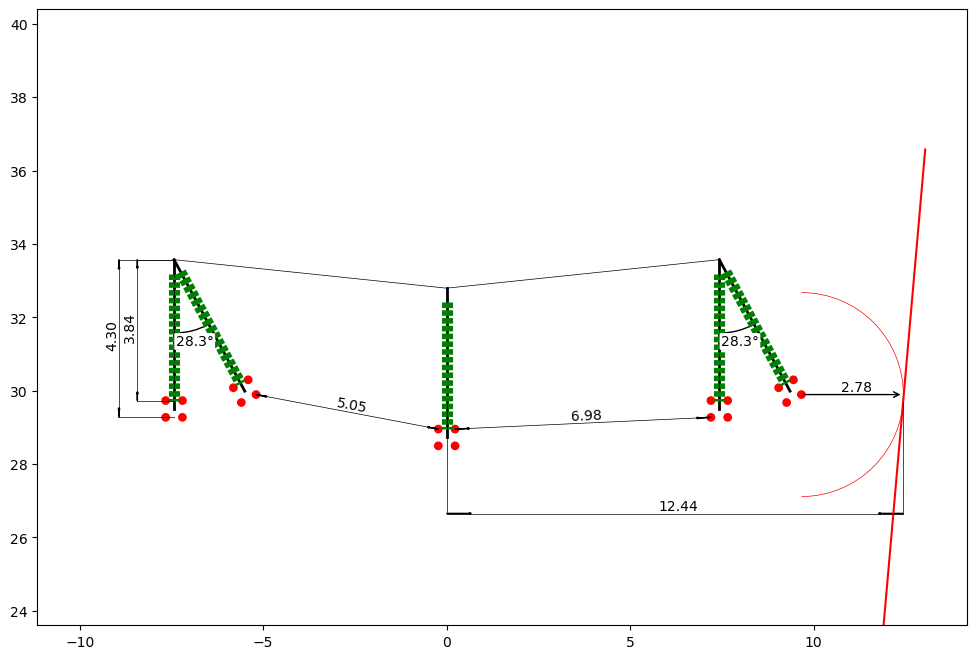

In [24]:
# Posição das fases
x2 = 0
dx = 7.43
x1 = x2 - dx
x3 = x2 + dx
# Altura cabo-solo, na torre
y2 = hTorre
deltaH = 0.777
y1 = y2 + deltaH
y3 = y2 + deltaH
y1t = y1 + lcadeia
y2t = y2 + lcadeia
y3t = y3 + lcadeia
dist1 = dftfl

ax = plt.figure()
ax.figure.set_size_inches(12, 8)
plt.plot([-10, 10], [0, 0],'k-', linewidth=0.5)
ptsF2 = plot_cadeia(plt, (x2,y2t), l=lcadeia, ang=0, nc=4, angsc=45, esp=espCond, wcad=8)
plt.plot([x1, x2, x3], [y1t, y2t, y3t],'k-', linewidth=0.5)
ptsF1 = plot_cadeia(plt, (x1,y1t), l=lcadeia, ang=0, nc=4, angsc=45, esp=espCond, wcad=8)
plot_dimension(plt, (x1,y1), (x1,y1t), offset=1)
plot_dimension(plt, (x1,y1-espCond), (x1,y1t), offset=1.5)
ptsF3fr = plot_cadeia(plt, (x3,y3t), l=lcadeia, ang=0, nc=4, angsc=45, esp=espCond, wcad=8)
p1,p2,_ = minDistancePts(ptsF2, ptsF3fr)
plot_dimension(plt, p1, p2, offset=0)
pm = xmax(ptsF3fl)
plot_distance_radius(plt, pm, radius=dist1)
ptsF3fl = plot_cadeia(plt, (x3,y3t), l=lcadeia, ang=ang1, nc=4, angsc=45, esp=espCond, wcad=8, angle_offset=2)
pm = xmax(ptsF3fi)
ptsF1fl = plot_cadeia(plt, (x1,y1t), l=lcadeia, ang=ang1, nc=4, angsc=45, esp=espCond, wcad=8, angle_offset=2)
p1,p2,_ = minDistancePts(ptsF2, ptsF1fl)
plot_dimension(plt, p2, p1, offset=0)
ptT,_,_ = find_line_start(ptsF3fl, 90-angM, dist1)
xm = plot_line_pt(plt, ptT, 90-angM, 0, y1t+3)
plot_dimension(plt, (0, ptT[1]), ptT, offset=-3)
plt.axis('equal')
plt.gca().set_ylim(30, 34)
plt.show()

## Parte 2 - versão 2024

### Altura condutor-solo (seção 7.2)

A título de exemplo, considerando aqui somente a altura típica nominal (a rigor deve-se observar as quatro condições):
$$
D_{Vtip,n} = P_{bV} + P_{stip} + P_{etip,n}
$$

Para a mesma premissa de acesso somente a pedestres: $k_g =$ 1.47, $P_{bV} =$ 4.20 m. A parcela elétrica $P_{etip,n}$ é calculada para a sobretensão de frente lenta (seção 9.4.1):
$$
P_e = 2.174 \left[ \exp \left( \frac{K_{CS} \, \sqrt 2 \, U_S \, F_{Sfl}}{1080 \, \sqrt 3 \, k_{afl} \, k_{zfl} \, k_g}\right) - 1\right]
$$
Usando $k_{zfl} = 1 - 1.3 \times 0.06$, recomendado pela norma, $K_{CS} = $ 1.35 (seção 7.2.5.1) e estimando $k_{afl}$ para uma distância de 10 m.

In [11]:
umidAbs = nbr5422.umidAbs(dra, tmed)
kafl = nbr5422.fatAtmFrenteLenta(dra, umidAbs, 10.) 
h, Petip, Pelim = nbr5422.distSegurancaVert(obs.PEDESTRE, amp.TIPICA_NOMINAL, 0.0, vNom, muft98, kafl) 
print(f"Altura mínima condutor-solo: {h:.2f} m. Parcelas elétricas: Petip = {Petip:.2f} m, Pelim = {Pelim:.2f} m")
hTorre = h + f50
print(f"Altura do condutor na torre: {hTorre:.2f} m.")

Altura mínima condutor-solo: 7.86 m. Parcelas elétricas: Petip = 2.34 m, Pelim = 2.16 m
Altura do condutor na torre: 28.95 m.


### Ventos de projeto

Para a versão 2024 aplica-se o fator de turbulência $K_{tur}$, considerado para a região Sul igual a 1.08, e o fator de integração $K_{int} =$ 1.22.
$$
V_{P30s} = K_{int} \, K_{tur} \, V_R
$$
Considerando a mesma velocidade base, obtida pelos parâmetros de Gumbel.

In [12]:
h = 17.0 # Altura preliminar do cabo condutor
V10t10m = nbr1985.correcaoVentoPeriodoRetornoSecao4(gumbelAlfa, gumbelBeta, 10)
Vp30s = nbr5422.fatCorrInt30s() * nbr5422.fatCorrAlt(h) * nbr5422.fatTurb(lt.types.regiao.S) * V10t10m
print(f"Vento de projeto, tempo de integração 30 s, período de retorno 10 anos: {Vp30s:.2f} m/s.")
V2t10m = nbr1985.correcaoVentoPeriodoRetornoSecao4(gumbelAlfa, gumbelBeta, 2)
VpRed = nbr5422.fatCorrInt30s() * nbr5422.fatCorrAlt(h) * nbr5422.fatTurb(lt.types.regiao.S) * V2t10m
print(f"Vento de projeto, tempo de integração 30 s, período de retorno 2 anos: {VpRed:.2f} m/s.")


Vento de projeto, tempo de integração 30 s, período de retorno 10 anos: 35.86 m/s.
Vento de projeto, tempo de integração 30 s, período de retorno 2 anos: 25.05 m/s.


### Ângulos de balanço

Para a versão 2024 aplica-se o desvio padrão para o ângulo máximo:
$$
\begin{align*}
\sigma_\beta & = 2.25 \left[1 - \exp \left( -\frac{V_p^2}{230}\right) \right] \\
\beta_{\max} & = \beta + 2 \sigma_\beta
\end{align*}
$$

Ângulos de balanço considerados (seção 9.6.2)

* Frequência fundamental: período de retorno mínimo de 10 anos.
* Impulso de frente lenta: período de retorno mínimo de 2 anos.
* Impulso de frente rápida: não considera ação do vento.

In [13]:
mu = nbr5422.massaAr(alt, tmed)
q010 = 0.5*mu*Vp30s**2
print(f"Pressão de vento: {q010:.2f} N/m²")
ang1 = nbr5422.anguloBalanco(Vp30s, q010, cond.d, cond.p, VpVv=vpvm)
ang1min, ang1max = nbr5422.anguloBalancoAssincrono(Vp30s, ang1)
ang1 = degrees(ang1)
ang1min = degrees(ang1min)
ang1max = degrees(ang1max)
print(f"Ângulo de balanço médio {ang1:.1f}°, mínimo {ang1min:.1f}º, máximo {ang1max:.1f}º.")
q02 = 0.5*mu*VpRed**2
print(f"Pressão de vento reduzida: {q02:.2f} N/m²")
ang2 = nbr5422.anguloBalanco(VpRed, q02, cond.d, cond.p, VpVv=vpvm)
ang2min, ang2max = nbr5422.anguloBalancoAssincrono(VpRed, ang2) 
ang2 = degrees(ang2)
ang2min = degrees(ang2min)
ang2max = degrees(ang2max)
print(f"Ângulo de balanço reduzido, médio {ang2:.1f}°, mínimo {ang2min:.1f}º, máximo {ang2max:.1f}º.")

Pressão de vento: 743.03 N/m²
Ângulo de balanço médio 31.9°, mínimo 27.4º, máximo 36.4º.
Pressão de vento reduzida: 362.63 N/m²
Ângulo de balanço reduzido, médio 19.5°, mínimo 15.3º, máximo 23.7º.


### Geometria da torre

#### Coordenação de isolamento (seção 9)

In [14]:
# Isolamento na tensão máxima frequência industrial
kg = 1.35 * kgfn - 0.35 * kgfn**2
dftfi = nbr5422.espacFTFreqFund(Us=vNom, Ftmo=ftmo, kaff=1., kgff=kg, zff=0.)
kg = 1.35 * kgff - 0.35 * kgff**2
dfffi = nbr5422.espacFFFreqFund(Us=vNom, Ftmo=ftmo, kaff=1., kgff=kg, zff=0.)
print(f"Distâncias para isolamento a frequência industrial: fase-terra {dftfi:.2f} m, fase-fase {dfffi:.2f} m.")

Distâncias para isolamento a frequência industrial: fase-terra 0.80 m, fase-fase 1.34 m.


In [15]:
# Isolamento a sobretensões de frente lenta
# Energização
kcs = 1.178 # Figura C.1, 50 gaps, risco 1e-2, Cvsfl 0.05, Cvfl 0.06
fsfl = muft98
dftfl = nbr5422.espacFTFrenteLenta(Us=vNom, Kcs=kcs, Fsfl=fsfl, kafl=FCAim, kg=kgfn)
kcs = 1.245 # Figura C.1, 1110 gaps, risco 1e-2, Cvsfl 0.05, Cvfl 0.06
fsfl = muff98
dfffl = nbr5422.espacFFFrenteLenta(Us=vNom, Kcs=kcs, Fsfl=fsfl, kafl=FCAim, kg=kgff, alpha=alpha)
print(f"Distâncias para isolamento sobretensões frente lenta: fase-terra {dftfl:.2f} m, fase-fase {dfffl:.2f} m.")

Distâncias para isolamento sobretensões frente lenta: fase-terra 2.38 m, fase-fase 2.85 m.


In [16]:
# Isolamento a sobretensões de frente rápida
bilp = cfop * (1 - 1.28*0.03)
biln = cfon * (1 - 1.28*0.03)
dftfrp = nbr5422.espacFTFrenteRapidaPos(bilp, kafr=dra, kg=kgfn) 
dftfrn = nbr5422.espacFTFrenteRapidaNeg(biln, kafr=dra, kg=kgfn) 
dfffr = nbr5422.espacFFFrenteRapida(bilp, kafr=dra, kg=kgff)
print(f"Distâncias para isolamento sobretensões frente lenta: fase-terra positiva {dftfrp:.2f} m, negativa {dftfrn:.2f} m, fase-fase {dfffr:.2f} m.")

Distâncias para isolamento sobretensões frente lenta: fase-terra positiva 3.79 m, negativa 4.04 m, fase-fase 4.31 m.


#### Esboço da cabeça da torre
Mesmo procedimento da versão 1985.

Considerar o balanço assícnrono na torre ($\beta_{min}$ e $\beta_{max}$) para determinação das distâncias entre fases (seção 9.6.3).

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


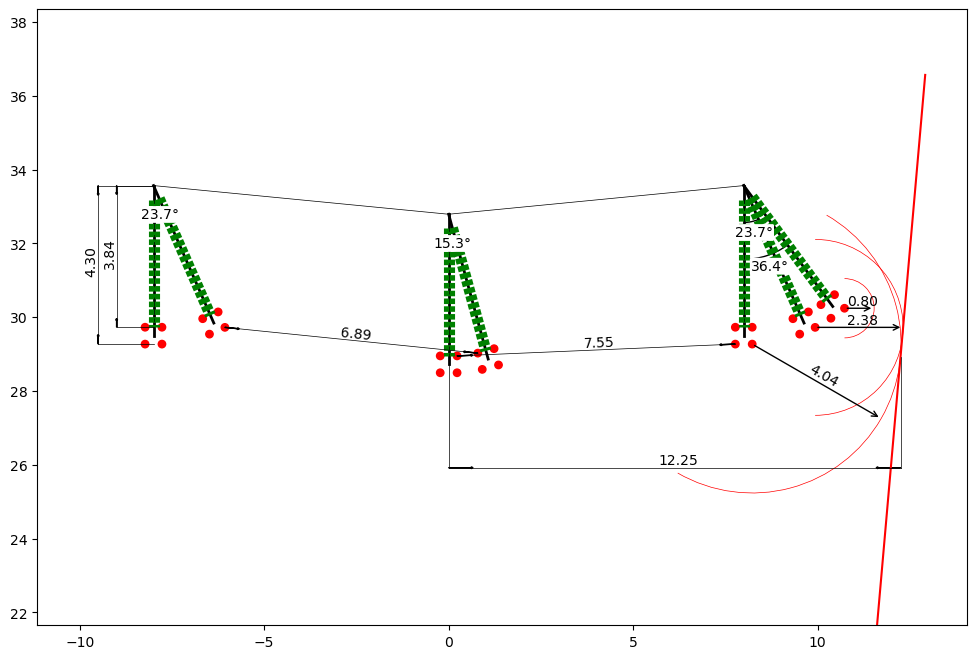

In [17]:
# Posição das fases
x2 = 0
dx = 8.
x1 = x2 - dx
x3 = x2 + dx
# Altura cabo-solo, na torre
y2 = hTorre
deltaH = 0.777
y1 = y2 + deltaH
y3 = y2 + deltaH
y1t = y1 + lcadeia
y2t = y2 + lcadeia
y3t = y3 + lcadeia
dist1 = dftfi
dist2 = dftfl
dist3 = max(dftfrp, dftfrn)

ax = plt.figure()
ax.figure.set_size_inches(12, 8)
plt.plot([-10, 10], [0, 0],'k-', linewidth=0.5)
ptsF2 = plot_cadeia(plt, (x2,y2t), l=lcadeia, ang=0, nc=4, angsc=45, esp=espCond, wcad=8)
plt.plot([x1, x2, x3], [y1t, y2t, y3t],'k-', linewidth=0.5)
ptsF1 = plot_cadeia(plt, (x1,y1t), l=lcadeia, ang=0, nc=4, angsc=45, esp=espCond, wcad=8)
plot_dimension(plt, (x1,y1), (x1,y1t), offset=1)
plot_dimension(plt, (x1,y1-espCond), (x1,y1t), offset=1.5)
ptsF3fr = plot_cadeia(plt, (x3,y3t), l=lcadeia, ang=0, nc=4, angsc=45, esp=espCond, wcad=8)
p1,p2,_ = minDistancePts(ptsF2, ptsF3fr)
plot_dimension(plt, p1, p2, offset=0)
pm = ptsF3fr[3]
plot_distance_radius(plt, pm, radius=dist3, angle=-30)
ptsF3fl = plot_cadeia(plt, (x3,y3t), l=lcadeia, ang=ang2max, nc=4, angsc=45, esp=espCond, wcad=8, angle_offset=1)
pm = xmax(ptsF3fl)
plot_distance_radius(plt, pm, radius=dist2)
ptsF3fi = plot_cadeia(plt, (x3,y3t), l=lcadeia, ang=ang1max, nc=4, angsc=45, esp=espCond, wcad=8, angle_offset=2)
pm = xmax(ptsF3fi)
plot_distance_radius(plt, pm, radius=dist1)
ptT,_,_ = find_line_start(ptsF3fr, 90-angM, dist3)
xm = plot_line_pt(plt, ptT, 90-angM, 0, y1t+3)
plot_dimension(plt, (0, ptT[1]), ptT, offset=-3)
ptsF1fl = plot_cadeia(plt, (x1,y1t), l=lcadeia, ang=ang2max, nc=4, angsc=45, esp=espCond, wcad=8)
ptsF2fl = plot_cadeia(plt, (x2,y2t), l=lcadeia, ang=ang2min, nc=4, angsc=45, esp=espCond, wcad=8)
p1,p2,_ = minDistancePts(ptsF1fl, ptsF2fl)
plot_dimension(plt, p1, p2, offset=0)

plt.axis('equal')
plt.gca().set_ylim(26, 34)
plt.show()

#### Balanço assíncrono

A seção 9.6.4 determina em usar a mesma premissa, $\beta_{min}$ e $\beta_{max}$, conforme seção 8.9.5. Em nota, recomenda-se os modelos da brochura CIGRE 348. 

Entende-se que a brochura, além de ser um livro texto com _recomendações_, considera o vento com período de retorno de 10 minutos, logo, por coerência, procura-se adotar a metodologia como um todo.

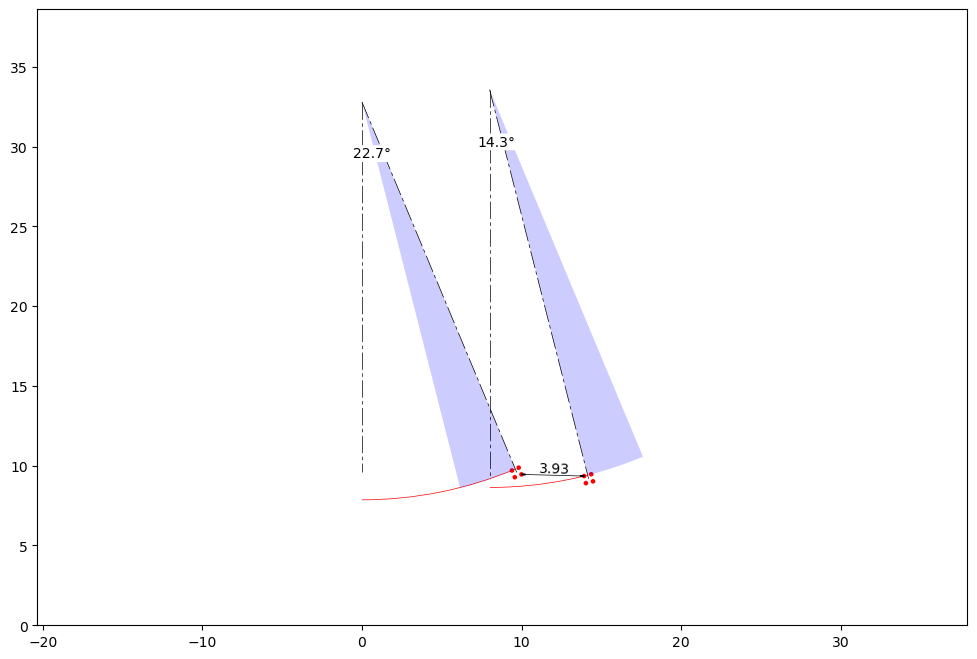

In [18]:
# Distâncias a meio do vão
ang1 = anguloBalancoTB348(V10t10m, cond.d, ncond, cond.p, piso, aiso, vVento, vPeso)
ang1min, ang1max = nbr5422.anguloBalancoAssincrono(V10t10m, ang1)
ang1 = degrees(ang1)
ang1min = degrees(ang1min)
ang1max = degrees(ang1max)
ax = plt.figure()
ax.figure.set_size_inches(12, 8)
ptsF2 = plot_balanco(plt, (x2,y2t), l=lcadeia+f50, ang=ang1max, angmin=ang1min, angmax=ang1max, nc=ncond, angsc=45, esp=espCond, angle_offset=3)
ptsF3 = plot_balanco(plt, (x3,y3t), l=lcadeia+f50, ang=ang1min, angmin=ang1min, angmax=ang1max, nc=ncond, angsc=45, esp=espCond, angle_offset=3)
p1,p2,_ = minDistancePts(ptsF2, ptsF3)
plot_dimension(plt, p1, p2, offset=0)
plt.axis('equal')
plt.gca().set_ylim(0, hCad+5)
plt.show()

### Distâncias de segurança

#### LD 34,5 kV - horizontal (paralelismo)

Considerando LT em balanço, LD em repouso. Ângulo referente a $\beta_{max}$ (seção 8.9.4), período de integração 30 s, período de retorno de 50 anos, temp. condutor igual a média das máximas do ar (seção 7.3.1.1).

Distância a partir da seção 9.4.2 (sobretensões de frente lenta, distância entre fases), considerando a maior tensão nominal.

#### LD 34,5 kV - vertical (cruzamento)

Figura 7. COnforme seção 7.2.5.2, somar a distância de segurança de ambas as linhas.

Considerando $k_g$ = 1.45, $P_{bV}$ = 0.80.